In [1]:
!pip install --upgrade seaborn

     |████████████████████████████████| 293 kB 8.3 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [3]:
dim = 512 #512, 256, 'original'
fold = 4

In [4]:
train_df = pd.read_csv(f'../input/vinbigdata-{dim}-image-dataset/vinbigdata/train.csv')
train_df.head()

image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   

    x_min   y_min   x_max   y_max  width  height  
0     NaN     NaN     NaN     NaN   2332    2580  
1     NaN     NaN     NaN     NaN   2954    3159  
2   691.0  1375.0  1653.0  1831.0   2080    2336  
3  1264.0   743.0  1611.0  1019.0   2304    2880  
4     NaN     NaN     NaN     NaN   2540    3072

In [5]:
train_df['image_path'] = f'/kaggle/input/vinbigdata-{dim}-image-dataset/vinbigdata/train/'+train_df.image_id+('.png' if dim!='original' else '.jpg')
train_df.head()

image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   

    x_min   y_min   x_max   y_max  width  height  \
0     NaN     NaN     NaN     NaN   2332    2580   
1     NaN     NaN     NaN     NaN   2954    3159   
2   691.0  1375.0  1653.0  1831.0   2080    2336   
3  1264.0   743.0  1611.0  1019.0   2304    2880   
4     NaN     NaN     NaN     NaN   2540    3072   

                                          image_path  
0  /kaggle/input/vinbigdata-512-image-dataset/vin...  
1  /kaggle/input/vinbigdata-512-image-dataset/vin...  
2  /kaggle/input/vinbigdata-512-image-dataset/vin...  
3  /kaggle/input/vinbigdata-512-image-dataset/vin...  
4  /kaggle/input/vinbigdata-512-image-dataset/vin...

# 14 Class

In [6]:
train_df = train_df[train_df.class_id!=14].reset_index(drop = True)

# Pre-Processing

In [7]:
train_df['x_min'] = train_df.apply(lambda row: (row.x_min)/row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min)/row.height, axis =1)

train_df['x_max'] = train_df.apply(lambda row: (row.x_max)/row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max)/row.height, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_df['area'] = train_df['w']*train_df['h']
train_df.head()

image_id          class_name  class_id rad_id  \
0  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
1  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
2  1c32170b4af4ce1a3030eb8167753b06  Pleural thickening        11     R9   
3  0c7a38f293d5f5e4846aa4ca6db4daf1                 ILD         5    R17   
4  47ed17dcb2cbeec15182ed335a8b5a9e         Nodule/Mass         8     R9   

      x_min     y_min     x_max     y_max  width  height  \
0  0.332212  0.588613  0.794712  0.783818   2080    2336   
1  0.548611  0.257986  0.699219  0.353819   2304    2880   
2  0.246850  0.116211  0.372835  0.140951   2540    3072   
3  0.589497  0.095890  0.957549  0.848924   2285    2555   
4  0.216900  0.701461  0.262850  0.740829   2568    3353   

                                          image_path     x_mid     y_mid  \
0  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.563462  0.686216   
1  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.623915  0.305903   
2  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.309843  0.128581   
3  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.773523  0.472407   
4  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.239875  0.721145   

          w         h      area  
0  0.462500  0.195205  0.090283  
1  0.150608  0.095833  0.014433  
2  0.125984  0.024740  0.003117  
3  0.368053  0.753033  0.277156  
4  0.045950  0.039368  0.001809

In [8]:
features = ['x_min', 'y_min', 'x_max', 'y_max', 'x_mid', 'y_mid', 'w', 'h', 'area']
X = train_df[features]
y = train_df['class_id']
X.shape, y.shape

((36096, 9), (36096,))

In [9]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

# t-SNE Visualization

In [ ]:
# %%time
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components = 2, perplexity = 40, random_state=1, n_iter=5000)
# data_X = X
# data_y = y.loc[data_X.index]
# embs = tsne.fit_transform(data_X)
# # Add to dataframe for convenience
# plot_x = embs[:, 0]
# plot_y = embs[:, 1]

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize = (15, 15))
# plt.axis('off')
# scatter = plt.scatter(plot_x, plot_y, marker = 'o',s = 50, c=data_y.tolist(), alpha= 0.5,cmap='viridis')
# plt.legend(handles=scatter.legend_elements()[0], labels=classes)

# BBox Location

## x_mid Vs y_mid

In [ ]:
# from scipy.stats import gaussian_kde


# x_val = train_df.x_mid.values
# y_val = train_df.y_mid.values

# # Calculate the point density
# xy = np.vstack([x_val,y_val])
# z = gaussian_kde(xy)(xy)

# fig, ax = plt.subplots(figsize = (10, 10))
# ax.axis('off')
# ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
# # ax.set_xlabel('x_mid')
# # ax.set_ylabel('y_mid')
# plt.show()

## bbox_w Vs bbox_h

In [ ]:
# x_val = train_df.w.values
# y_val = train_df.h.values

# # Calculate the point density
# xy = np.vstack([x_val,y_val])
# z = gaussian_kde(xy)(xy)

# fig, ax = plt.subplots(figsize = (10, 10))
# ax.axis('off')
# ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
# # ax.set_xlabel('bbox_width')
# # ax.set_ylabel('bbox_height')
# plt.show()

# Image Aspect Ratio

In [ ]:
# x_val = train_df.width.values
# y_val = train_df.height.values

# # Calculate the point density
# xy = np.vstack([x_val,y_val])
# z = gaussian_kde(xy)(xy)

# fig, ax = plt.subplots(figsize = (10, 10))
# ax.axis('off')
# ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
# # ax.set_xlabel('image_width')
# # ax.set_ylabel('image_height')
# plt.show()

# Split

In [10]:
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.head()

image_id          class_name  class_id rad_id  \
0  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
1  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
2  1c32170b4af4ce1a3030eb8167753b06  Pleural thickening        11     R9   
3  0c7a38f293d5f5e4846aa4ca6db4daf1                 ILD         5    R17   
4  47ed17dcb2cbeec15182ed335a8b5a9e         Nodule/Mass         8     R9   

      x_min     y_min     x_max     y_max  width  height  \
0  0.332212  0.588613  0.794712  0.783818   2080    2336   
1  0.548611  0.257986  0.699219  0.353819   2304    2880   
2  0.246850  0.116211  0.372835  0.140951   2540    3072   
3  0.589497  0.095890  0.957549  0.848924   2285    2555   
4  0.216900  0.701461  0.262850  0.740829   2568    3353   

                                          image_path     x_mid     y_mid  \
0  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.563462  0.686216   
1  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.623915  0.305903   
2  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.309843  0.128581   
3  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.773523  0.472407   
4  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.239875  0.721145   

          w         h      area  fold  
0  0.462500  0.195205  0.090283     3  
1  0.150608  0.095833  0.014433     2  
2  0.125984  0.024740  0.003117     4  
3  0.368053  0.753033  0.277156     2  
4  0.045950  0.039368  0.001809     4

In [ ]:
train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())

# Copying Files

In [12]:
os.makedirs('/kaggle/working/vinbigdata/labels/train', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdata/labels/val', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdata/images/train', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdata/images/val', exist_ok = True)
label_dir = '/kaggle/input/vinbigdata-yolo-labels-dataset/labels'

for file in tqdm(train_files):
    shutil.copy(file, '/kaggle/working/vinbigdata/images/train')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/kaggle/working/vinbigdata/labels/train')
    
for file in tqdm(val_files):
    shutil.copy(file, '/kaggle/working/vinbigdata/images/val')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/kaggle/working/vinbigdata/labels/val')

# Get Class Name

In [13]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [14]:
from os import listdir
from os.path import isfile, join
import yaml

cwd = '/kaggle/working/'

with open(join( cwd , 'train.txt'), 'w') as f:
    for path in glob('/kaggle/working/vinbigdata/images/train/*'):
        f.write(path+'\n')
            
with open(join( cwd , 'val.txt'), 'w') as f:
    for path in glob('/kaggle/working/vinbigdata/images/val/*'):
        f.write(path+'\n')

data = dict(
    train =  join( cwd , 'train.txt') ,
    val   =  join( cwd , 'val.txt' ),
    nc    = 14,
    names = classes
    )

with open(join( cwd , 'vinbigdata.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'vinbigdata.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Aortic enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung Opacity
- Nodule/Mass
- Other lesion
- Pleural effusion
- Pleural thickening
- Pneumothorax
- Pulmonary fibrosis
nc: 14
train: /kaggle/working/train.txt
val: /kaggle/working/val.txt



In [15]:
# https://www.kaggle.com/ultralytics/yolov5
# !git clone https://github.com/ultralytics/yolov5  # clone repo
# %cd yolov5
shutil.copytree('/kaggle/input/yolov5-official-v31-dataset/yolov5', '/kaggle/working/yolov5')
os.chdir('/kaggle/working/yolov5')
# %pip install -qr requirements.txt # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.6.0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16269MB, multi_processor_count=56)


In [16]:
!python detect.py --weights yolov5s.pt --img 512 --conf 0.25 --source data/images/
Image(filename='runs/detect/exp/zidane.jpg', width=512)

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=512, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='data/images/', update=False, view_img=False, weights=['yolov5s.pt'])
100%|██████████████████████████████████████| 14.5M/14.5M [00:00<00:00, 56.7MB/s]

^C


FileNotFoundError: [Errno 2] No such file or directory: 'runs/detect/exp/zidane.jpg'

# Selecting Models
using `v5s`. To select your prefered model just replace `--cfg models/yolov5s.yaml --weights yolov5s.pt` with the following command:
* `v5s` : `--cfg models/yolov5s.yaml --weights yolov5s.pt`
* `v5m` : `--cfg models/yolov5m.yaml --weights yolov5m.pt`
* `v5l` : `--cfg models/yolov5l.yaml --weights yolov5l.pt`
* `v5x` : `--cfg models/yolov5x.yaml --weights yolov5x.pt`

# Train

In [17]:
# !WANDB_MODE="dryrun" python train.py --img 512 --batch 16 --epochs 3 --data coco128.yaml --weights yolov5s.pt --nosave --cache 
!WANDB_MODE="dryrun" python train.py --img 512 --batch 16 --epochs 30 --data /kaggle/working/vinbigdata.yaml --weights yolov5x.pt --cache

100%|████████████████████████████████████████| 170M/170M [00:04<00:00, 44.2MB/s]

wandb: Offline run mode, not syncing to the cloud.
wandb: W&B is disabled in this directory.  Run `wandb on` to enable cloud syncing.
Scanning '/kaggle/working/vinbigdata/labels/train' for images and labels... 3515 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 3515/3515 [00:01<00:00, 1772.75it/s]
Scanning '/kaggle/working/vinbigdata/labels/train.cache' for images and labels... 3515 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 3515/3515 [00:00<00:00, 15869729.34it/s]
Caching images (2.8GB): 100%|██████████| 3515/3515 [00:04<00:00, 723.64it/s]
Scanning '/kaggle/working/vinbigdata/labels/val' for images and labels... 879 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 879/879 [00:00<00:00, 1054.98it/s]
Scanning '/kaggle/working/vinbigdata/labels/val.cache' for images and labels... 879 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 879/879 [00:00<00:00, 5071242.39it/s

# Class Distribution

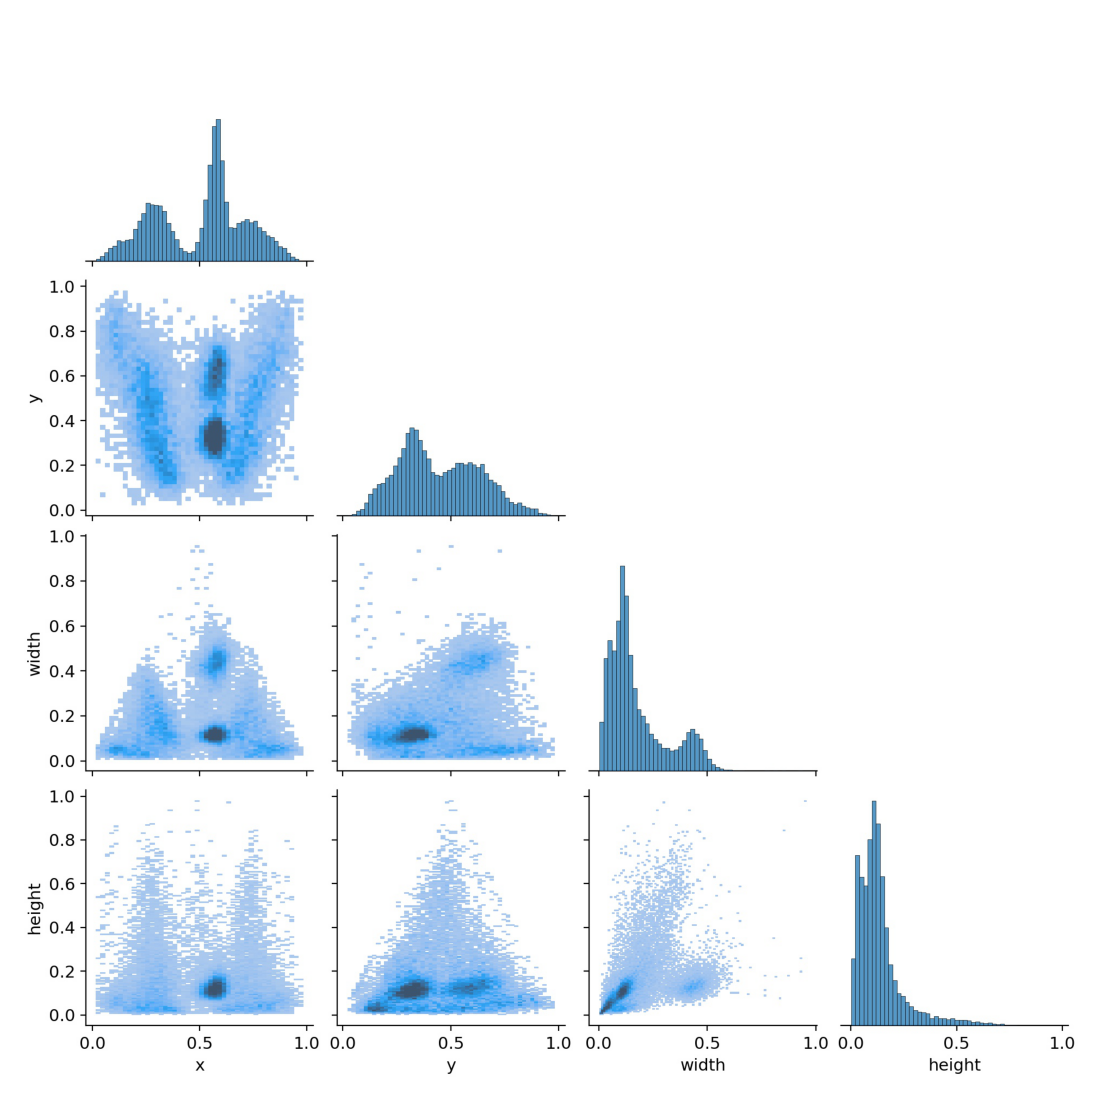

In [18]:
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels_correlogram.jpg'));

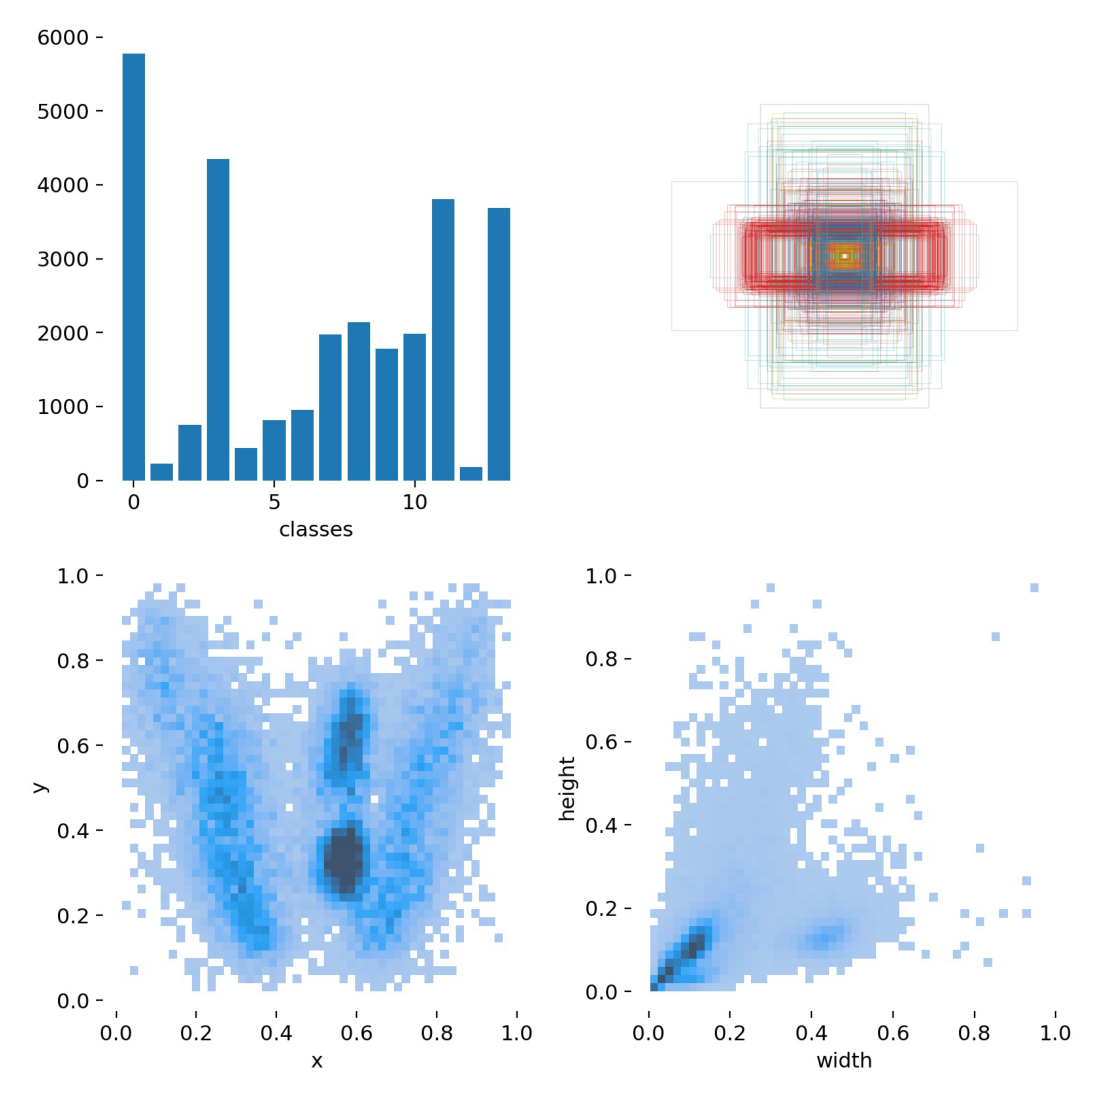

In [19]:
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels.jpg'));

# Batch Image

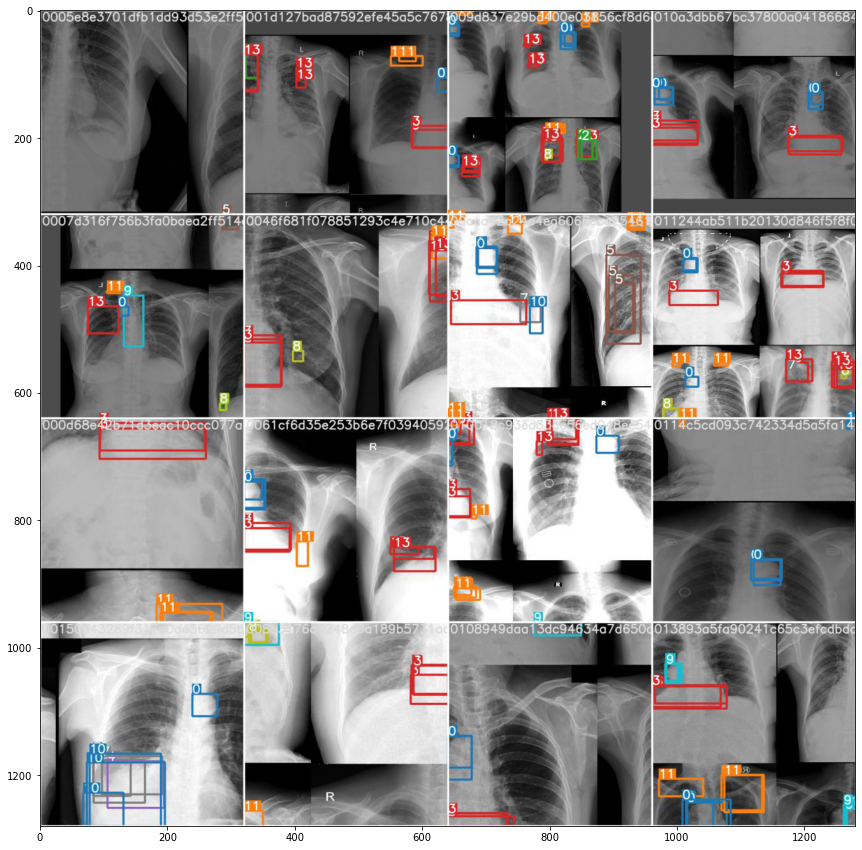

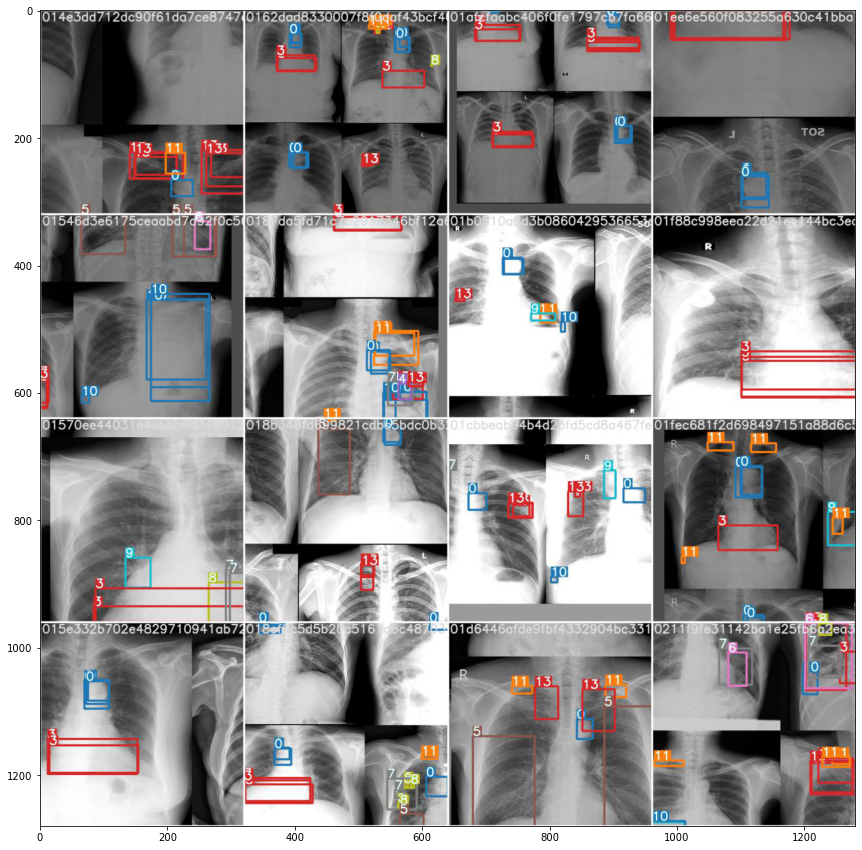

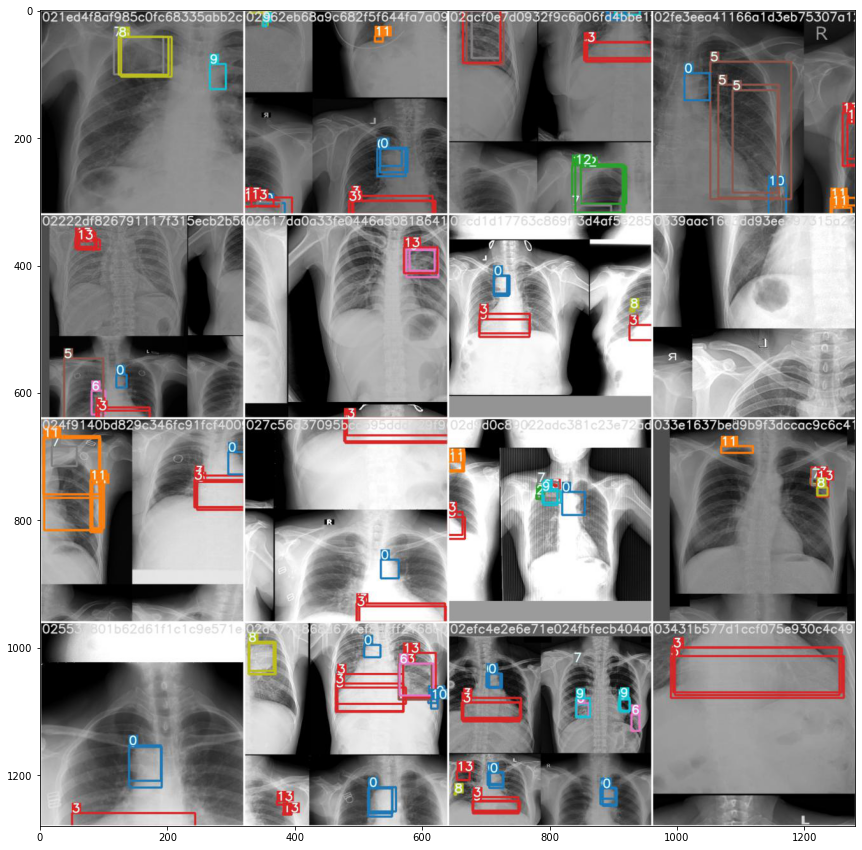

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp/train_batch0.jpg'))

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp/train_batch1.jpg'))

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp/train_batch2.jpg'))

# GT Vs Pred

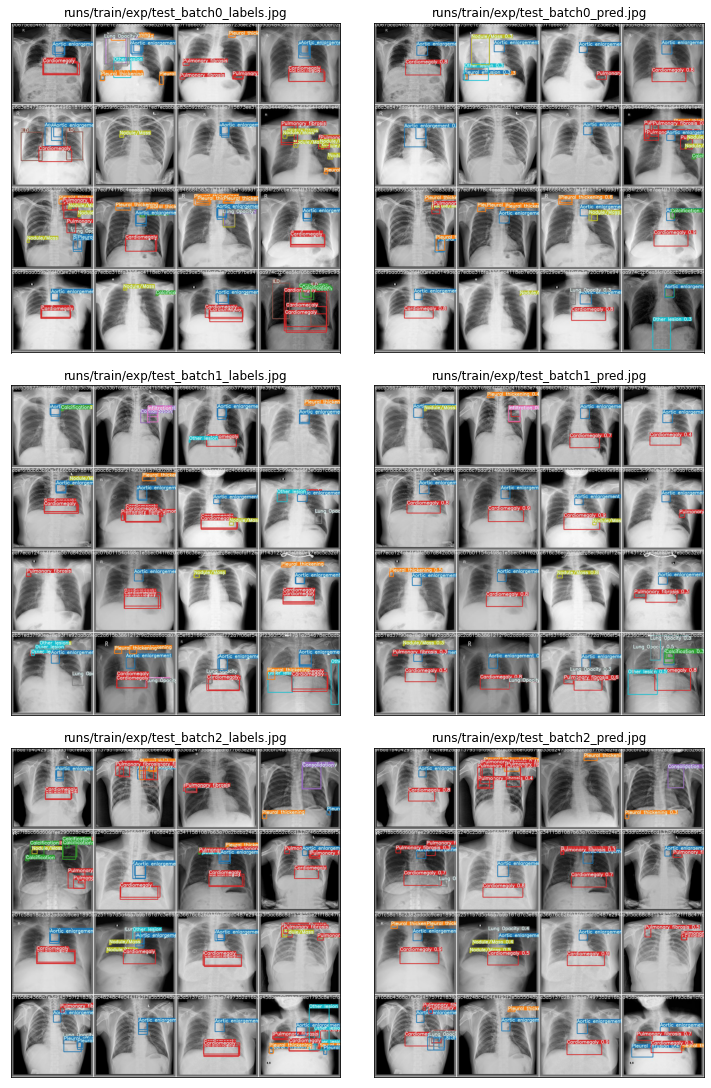

In [21]:
fig, ax = plt.subplots(3, 2, figsize = (2*5,3*5), constrained_layout = True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'runs/train/exp/test_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'runs/train/exp/test_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'runs/train/exp/test_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'runs/train/exp/test_batch{row}_pred.jpg', fontsize = 12)

# (Loss, Map) Vs Epoch

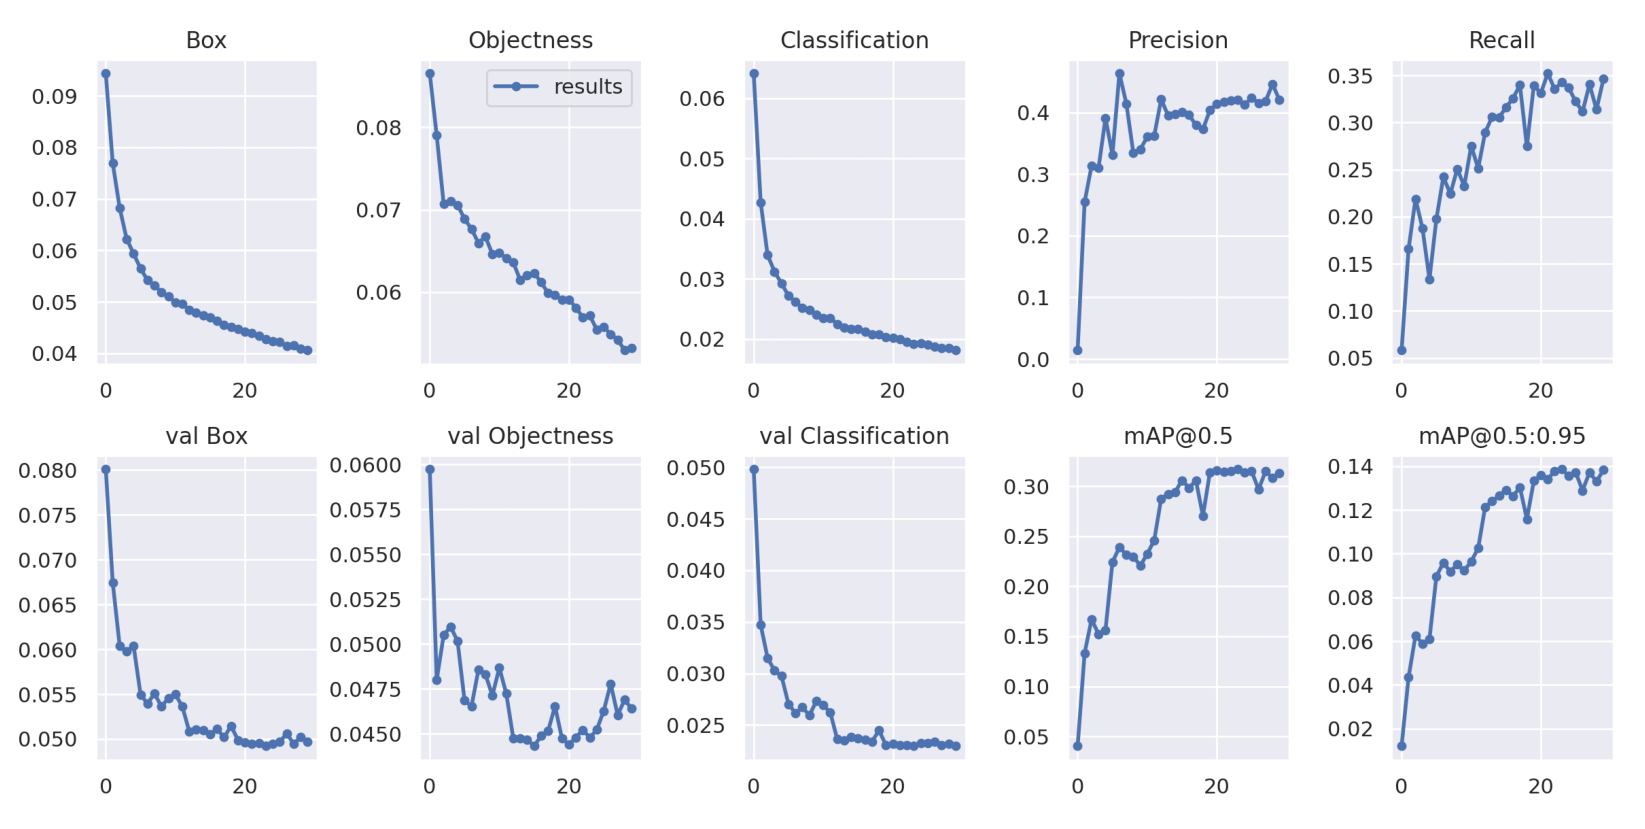

In [22]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/results.png'));

# Confusion Matrix

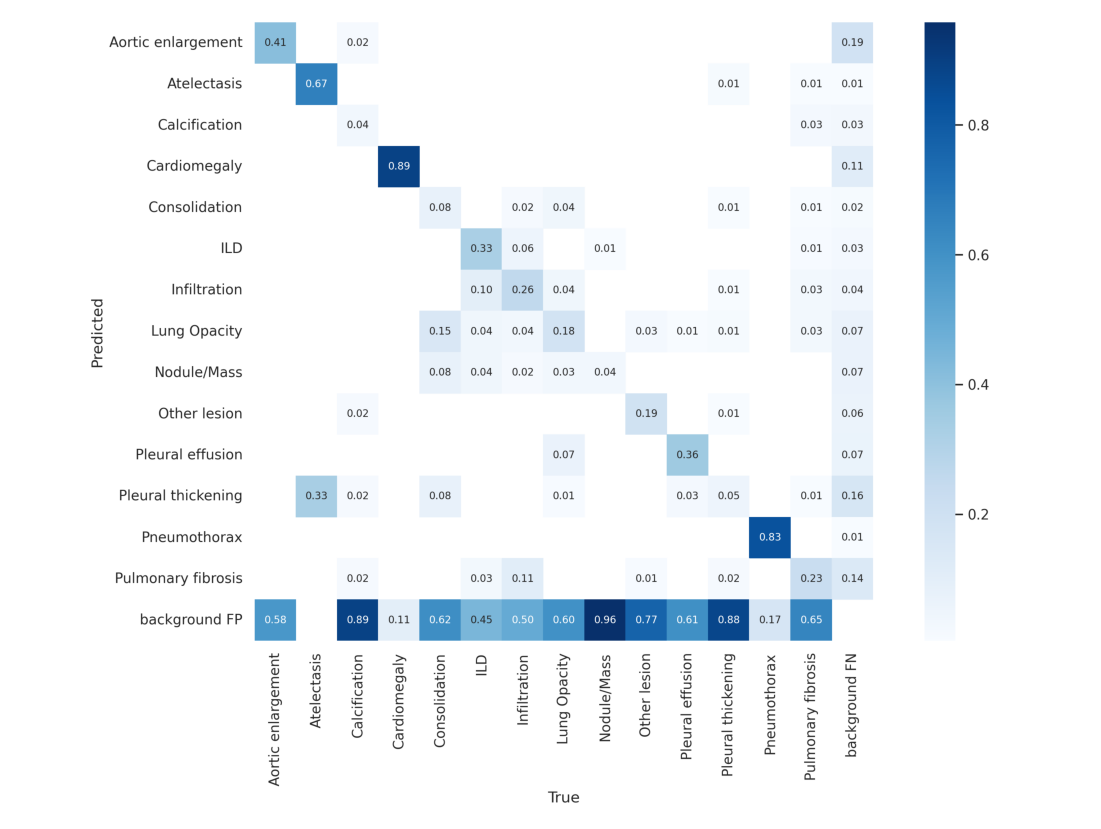

In [23]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/confusion_matrix.png'));

# Inference

In [ ]:
!python detect.py --weights 'runs/train/exp/weights/best.pt'\
--img 512\
--conf 0.15\
--iou 0.5\
--source /kaggle/working/vinbigdata/images/val\
--exist-ok

# Inference Plot

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import cv2
from glob import glob
from tqdm import tqdm

files = glob('runs/detect/exp/*')
for _ in range(3):
    row = 4
    col = 4
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img          = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(img)

    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

ValueError: Sample larger than population or is negative

In [ ]:
# shutil.rmtree('/kaggle/working/vinbigdata')
# shutil.rmtree('runs/detect')
# for file in (glob('runs/train/exp/**/*.png', recursive = True)+glob('runs/train/exp/**/*.jpg', recursive = True)):
#     os.remove(file)

In [36]:
!ls runs/train/exp/weights/

best.pt  last.pt


In [38]:
!zip -r runs_weight.zip . runs/

  adding: runs.zip (stored 0%)
  adding: yolov5x.pt (deflated 8%)
  adding: .github/ (stored 0%)
  adding: .github/ISSUE_TEMPLATE/ (stored 0%)
  adding: .github/ISSUE_TEMPLATE/question.md (deflated 21%)
  adding: .github/ISSUE_TEMPLATE/bug-report.md (deflated 41%)
  adding: .github/ISSUE_TEMPLATE/feature-request.md (deflated 48%)
  adding: .github/workflows/ (stored 0%)
  adding: .github/workflows/greetings.yml (deflated 60%)
  adding: .github/workflows/stale.yml (deflated 55%)
  adding: .github/workflows/rebase.yml (deflated 44%)
  adding: .github/workflows/codeql-analysis.yml (deflated 51%)
  adding: .github/workflows/ci-testing.yml (deflated 62%)
  adding: wandb/ (stored 0%)
  adding: wandb/debug.log (deflated 95%)
  adding: wandb/offline-run-20251201_092322-3nu2pb4g/ (stored 0%)
  adding: wandb/offline-run-20251201_092322-3nu2pb4g/run-3nu2pb4g.wandb (deflated 84%)
  adding: wandb/offline-run-20251201_092322-3nu2pb4g/files/ (stored 0%)
  adding: wandb/offline-run-20251201_092322-3nu

In [43]:
!cp runs_weight.zip /kaggle/working/